# Rasch Model (1PL IRT) Validation Study
## Math Mock Exam Platform — Psychometric Validation

This notebook validates our Rasch model implementation by:
1. Generating synthetic response data with **known** parameters
2. Running calibration and checking **parameter recovery**
3. Analyzing **Item Characteristic Curves** (ICCs)
4. Computing **fit statistics** (infit/outfit)
5. Testing **sample size sensitivity**
6. Simulating a **realistic 55-item math exam**

In [1]:
import sys, os
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats

# Add backend to path
sys.path.insert(0, os.path.join(os.path.dirname('__file__'), '..', 'backend'))
from exams.rasch import rasch_probability, estimate_theta, estimate_item_difficulties, compute_item_fit

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 12

np.random.seed(42)
print("All imports successful")
print(f"NumPy version: {np.__version__}")

All imports successful
NumPy version: 2.2.3


## 1. Synthetic Data Generation

We generate response data from **known** item difficulties (beta) and student abilities (theta). If our calibration algorithm works correctly, it should **recover** these parameters.

In [2]:
def generate_response_matrix(true_thetas, true_betas, seed=42):
    """Generate binary response matrix from known Rasch parameters.
    
    Args:
        true_thetas: array of student abilities
        true_betas: array of item difficulties
        seed: random seed for reproducibility
    
    Returns:
        N x J binary matrix where entry (i,j) = 1 if student i answered item j correctly
    """
    rng = np.random.RandomState(seed)
    N, J = len(true_thetas), len(true_betas)
    matrix = np.zeros((N, J))
    
    for i in range(N):
        for j in range(J):
            p = rasch_probability(true_thetas[i], true_betas[j])
            matrix[i, j] = 1.0 if rng.random() < p else 0.0
    
    # Summary
    print(f"Generated {N} students x {J} items response matrix")
    print(f"Overall correct rate: {matrix.mean():.1%}")
    print(f"True theta range: [{true_thetas.min():.2f}, {true_thetas.max():.2f}]")
    print(f"True beta range: [{true_betas.min():.2f}, {true_betas.max():.2f}]")
    
    return matrix

# Quick test
test_matrix = generate_response_matrix(
    np.array([0.0, 1.0, -1.0]),
    np.array([-1.0, 0.0, 1.0]),
    seed=42
)
print(f"\nTest matrix:\n{test_matrix}")

Generated 3 students x 3 items response matrix
Overall correct rate: 55.6%
True theta range: [-1.00, 1.00]
True beta range: [-1.00, 1.00]

Test matrix:
[[1. 0. 0.]
 [1. 1. 1.]
 [1. 0. 0.]]


## 2. Parameter Recovery

The most critical validation: can our JMLE algorithm recover the **true** item difficulties from response data?

We test at three scales:
- **Small:** 20 students x 10 items
- **Medium:** 100 students x 55 items (matching our exam)
- **Large:** 1000 students x 55 items (production target)


  Small (20x10)
Generated 20 students x 10 items response matrix
Overall correct rate: 46.0%
True theta range: [-1.91, 1.58]
True beta range: [-2.50, 2.50]
  beta correlation: 0.9474
  beta RMSE: 0.5355

  Medium (100x55)
Generated 100 students x 55 items response matrix
Overall correct rate: 48.3%
True theta range: [-2.62, 1.85]
True beta range: [-2.50, 2.50]
  beta correlation: 0.9813
  beta RMSE: 0.2991

  Large (1000x55)
Generated 1000 students x 55 items response matrix
Overall correct rate: 50.1%
True theta range: [-3.24, 3.85]
True beta range: [-2.50, 2.50]


  beta correlation: 0.9984
  beta RMSE: 0.0922


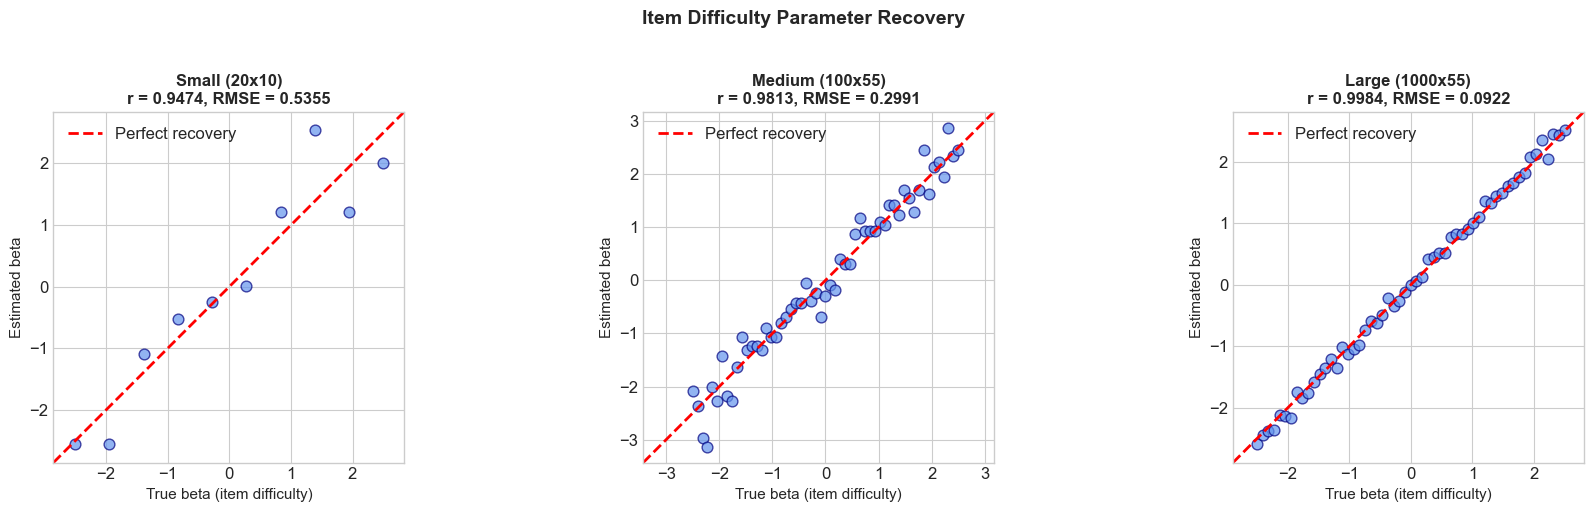


Plot saved as parameter_recovery.png


In [3]:
def run_recovery_analysis(N, J, true_beta_range=(-2.5, 2.5), theta_mean=0, theta_sd=1.0, seed=42):
    """Run parameter recovery analysis at given scale."""
    rng = np.random.RandomState(seed)
    true_betas = np.linspace(true_beta_range[0], true_beta_range[1], J)
    true_thetas = rng.normal(theta_mean, theta_sd, N)
    
    matrix = generate_response_matrix(true_thetas, true_betas, seed=seed)
    est_betas, est_thetas = estimate_item_difficulties(matrix)
    
    # Center both for comparison (Rasch model is identified up to a constant)
    true_centered = true_betas - true_betas.mean()
    est_centered = est_betas - est_betas.mean()
    
    # Metrics
    corr = np.corrcoef(true_centered, est_centered)[0, 1]
    rmse = np.sqrt(np.mean((true_centered - est_centered) ** 2))
    
    return {
        'true_betas': true_centered,
        'est_betas': est_centered,
        'true_thetas': true_thetas,
        'est_thetas': est_thetas,
        'corr': corr,
        'rmse': rmse,
        'N': N,
        'J': J,
        'matrix': matrix,
    }

# Run all three scales
scales = [
    ("Small (20x10)", 20, 10),
    ("Medium (100x55)", 100, 55),
    ("Large (1000x55)", 1000, 55),
]

results = {}
for label, N, J in scales:
    print(f"\n{'='*50}")
    print(f"  {label}")
    print(f"{'='*50}")
    r = run_recovery_analysis(N, J, seed=42)
    results[label] = r
    print(f"  beta correlation: {r['corr']:.4f}")
    print(f"  beta RMSE: {r['rmse']:.4f}")

# Plot all three
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (label, r) in zip(axes, results.items()):
    ax.scatter(r['true_betas'], r['est_betas'], alpha=0.7, edgecolors='navy', facecolors='cornflowerblue', s=60)
    
    # Perfect recovery line
    lims = [min(r['true_betas'].min(), r['est_betas'].min()) - 0.3,
            max(r['true_betas'].max(), r['est_betas'].max()) + 0.3]
    ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect recovery')
    
    ax.set_xlabel('True beta (item difficulty)', fontsize=11)
    ax.set_ylabel('Estimated beta', fontsize=11)
    ax.set_title(f'{label}\nr = {r["corr"]:.4f}, RMSE = {r["rmse"]:.4f}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.suptitle('Item Difficulty Parameter Recovery', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('parameter_recovery.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nPlot saved as parameter_recovery.png")

## 3. Item Characteristic Curves (ICCs)

ICCs show the probability of a correct response as a function of student ability (theta) for each item. In the Rasch model, all ICCs have the same slope (discrimination = 1) but are shifted left/right by their difficulty (beta).

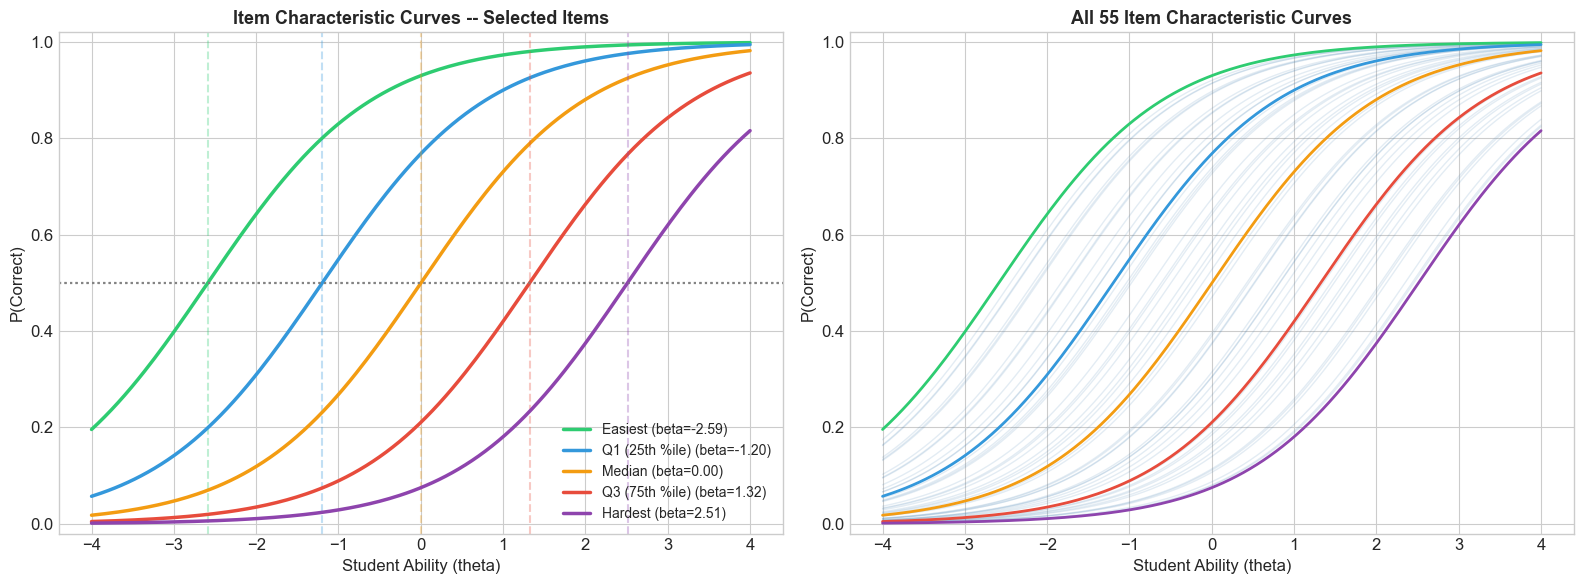

ICC curves saved as icc_curves.png


In [4]:
# Use the large-scale results for ICC plots
r = results["Large (1000x55)"]
est_betas = r['est_betas']

# Select representative items: easiest, 25th percentile, median, 75th, hardest
indices = [0, len(est_betas)//4, len(est_betas)//2, 3*len(est_betas)//4, len(est_betas)-1]
labels = ['Easiest', 'Q1 (25th %ile)', 'Median', 'Q3 (75th %ile)', 'Hardest']
colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#8e44ad']

theta_range = np.linspace(-4, 4, 200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Selected ICCs
for idx, label, color in zip(indices, labels, colors):
    probs = [rasch_probability(t, est_betas[idx]) for t in theta_range]
    ax1.plot(theta_range, probs, color=color, linewidth=2.5, label=f'{label} (beta={est_betas[idx]:.2f})')
    ax1.axhline(y=0.5, color='gray', linestyle=':', alpha=0.5)
    ax1.axvline(x=est_betas[idx], color=color, linestyle='--', alpha=0.3)

ax1.set_xlabel('Student Ability (theta)', fontsize=12)
ax1.set_ylabel('P(Correct)', fontsize=12)
ax1.set_title('Item Characteristic Curves -- Selected Items', fontsize=13, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.set_ylim(-0.02, 1.02)

# Right: All ICCs overlaid (shows the family of curves)
for j in range(len(est_betas)):
    probs = [rasch_probability(t, est_betas[j]) for t in theta_range]
    ax2.plot(theta_range, probs, color='steelblue', alpha=0.15, linewidth=1)

# Highlight the 5 selected ones
for idx, color in zip(indices, colors):
    probs = [rasch_probability(t, est_betas[idx]) for t in theta_range]
    ax2.plot(theta_range, probs, color=color, linewidth=2)

ax2.set_xlabel('Student Ability (theta)', fontsize=12)
ax2.set_ylabel('P(Correct)', fontsize=12)
ax2.set_title('All 55 Item Characteristic Curves', fontsize=13, fontweight='bold')
ax2.set_ylim(-0.02, 1.02)

plt.tight_layout()
plt.savefig('icc_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print("ICC curves saved as icc_curves.png")

## 4. Fit Statistics

**Infit** (information-weighted) and **Outfit** (outlier-sensitive) Mean Square statistics measure how well items conform to the Rasch model. 

- **Expected value:** 1.0 (perfect fit)
- **Acceptable range:** 0.7 -- 1.3
- **Degrading:** < 0.7 (overfit/redundant) or > 1.3 (underfit/noisy)
- **Distorting:** > 2.0 (severe misfit)

Since our data is generated FROM the Rasch model, all items should fit well.

  FIT STATISTICS SUMMARY (1000 students x 55 items)

  Infit MNSQ:  mean = 0.999, SD = 0.028
               range = [0.946, 1.064]

  Outfit MNSQ: mean = 1.001, SD = 0.081
               range = [0.842, 1.359]

  Items with infit outside [0.7, 1.3]: 0/55
  Items with outfit outside [0.7, 1.3]: 1/55


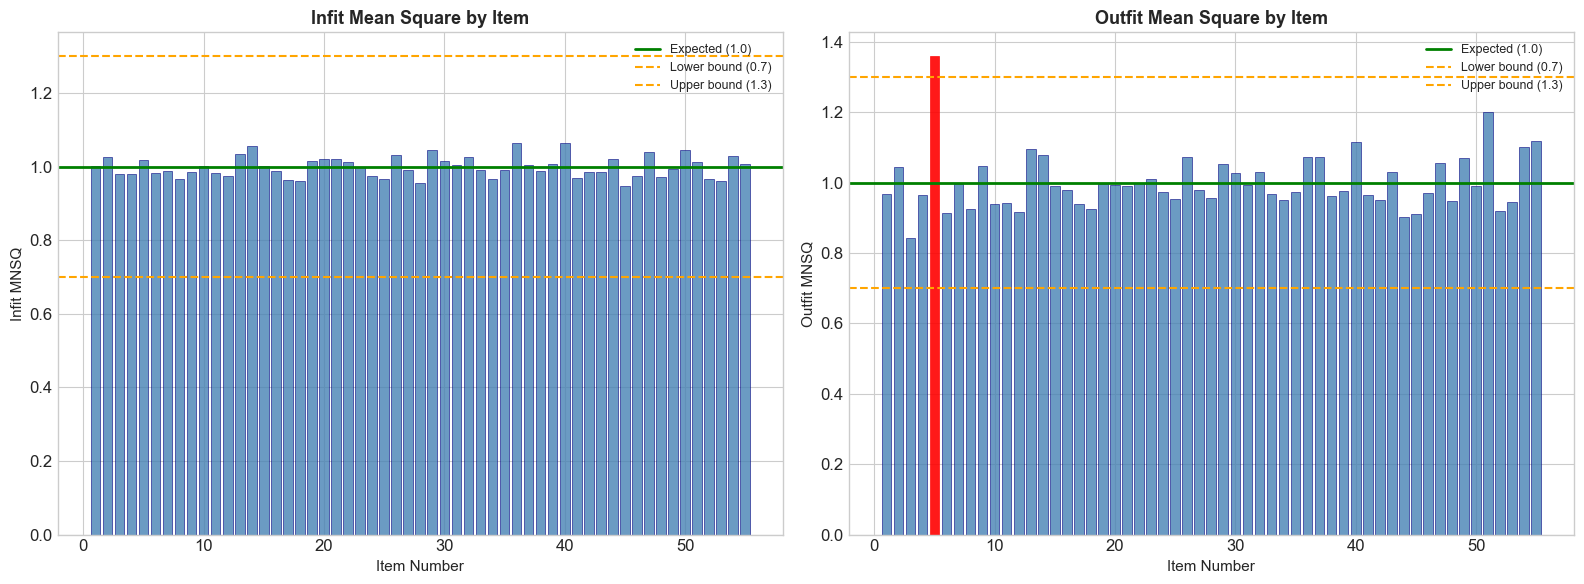

Fit statistics plot saved


In [5]:
r = results["Large (1000x55)"]
matrix = r['matrix']
est_betas = r['est_betas']
est_thetas = r['est_thetas']

# Compute fit for all items
fit_data = []
for j in range(len(est_betas)):
    fit = compute_item_fit(j, matrix, est_thetas, est_betas)
    fit_data.append({
        'item': j + 1,
        'beta': est_betas[j],
        'infit': fit['infit'],
        'outfit': fit['outfit'],
    })

infits = np.array([f['infit'] for f in fit_data])
outfits = np.array([f['outfit'] for f in fit_data])

# Summary
print("=" * 60)
print("  FIT STATISTICS SUMMARY (1000 students x 55 items)")
print("=" * 60)
print(f"\n  Infit MNSQ:  mean = {infits.mean():.3f}, SD = {infits.std():.3f}")
print(f"               range = [{infits.min():.3f}, {infits.max():.3f}]")
print(f"\n  Outfit MNSQ: mean = {outfits.mean():.3f}, SD = {outfits.std():.3f}")
print(f"               range = [{outfits.min():.3f}, {outfits.max():.3f}]")

# Flag misfitting items
misfit_infit = np.sum((infits < 0.7) | (infits > 1.3))
misfit_outfit = np.sum((outfits < 0.7) | (outfits > 1.3))
print(f"\n  Items with infit outside [0.7, 1.3]: {misfit_infit}/{len(infits)}")
print(f"  Items with outfit outside [0.7, 1.3]: {misfit_outfit}/{len(outfits)}")

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Infit bar chart
bars1 = ax1.bar(range(1, len(infits)+1), infits, color='steelblue', alpha=0.8, edgecolor='navy', linewidth=0.5)
ax1.axhline(y=1.0, color='green', linewidth=2, label='Expected (1.0)')
ax1.axhline(y=0.7, color='orange', linewidth=1.5, linestyle='--', label='Lower bound (0.7)')
ax1.axhline(y=1.3, color='orange', linewidth=1.5, linestyle='--', label='Upper bound (1.3)')
ax1.set_xlabel('Item Number', fontsize=11)
ax1.set_ylabel('Infit MNSQ', fontsize=11)
ax1.set_title('Infit Mean Square by Item', fontsize=13, fontweight='bold')
ax1.legend(fontsize=9)

# Color misfitting bars
for i, (bar, val) in enumerate(zip(bars1, infits)):
    if val < 0.7 or val > 1.3:
        bar.set_color('red')
        bar.set_alpha(0.9)

# Outfit bar chart
bars2 = ax2.bar(range(1, len(outfits)+1), outfits, color='steelblue', alpha=0.8, edgecolor='navy', linewidth=0.5)
ax2.axhline(y=1.0, color='green', linewidth=2, label='Expected (1.0)')
ax2.axhline(y=0.7, color='orange', linewidth=1.5, linestyle='--', label='Lower bound (0.7)')
ax2.axhline(y=1.3, color='orange', linewidth=1.5, linestyle='--', label='Upper bound (1.3)')
ax2.set_xlabel('Item Number', fontsize=11)
ax2.set_ylabel('Outfit MNSQ', fontsize=11)
ax2.set_title('Outfit Mean Square by Item', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9)

for i, (bar, val) in enumerate(zip(bars2, outfits)):
    if val < 0.7 or val > 1.3:
        bar.set_color('red')
        bar.set_alpha(0.9)

plt.tight_layout()
plt.savefig('fit_statistics.png', dpi=150, bbox_inches='tight')
plt.show()
print("Fit statistics plot saved")

## 5. Person Fit -- Student Ability Recovery

Can we recover individual student abilities (theta)?

  PERSON FIT (theta Recovery)
  Correlation:  0.9455
  RMSE:         0.3439


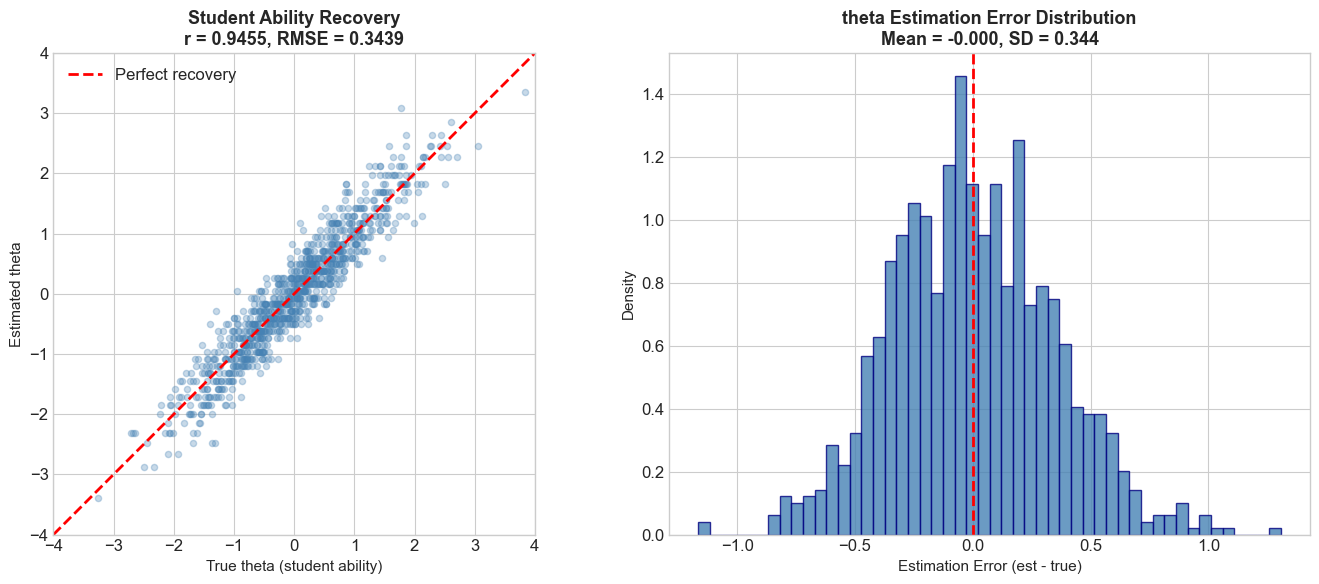

Person fit plot saved


In [6]:
r = results["Large (1000x55)"]

# True vs estimated thetas
true_t = r['true_thetas']
est_t = r['est_thetas']

# Center both
true_t_c = true_t - true_t.mean()
est_t_c = est_t - est_t.mean()

corr_theta = np.corrcoef(true_t_c, est_t_c)[0, 1]
rmse_theta = np.sqrt(np.mean((true_t_c - est_t_c) ** 2))

print("=" * 50)
print("  PERSON FIT (theta Recovery)")
print("=" * 50)
print(f"  Correlation:  {corr_theta:.4f}")
print(f"  RMSE:         {rmse_theta:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scatter
ax1.scatter(true_t_c, est_t_c, alpha=0.3, s=20, color='steelblue')
lims = [-4, 4]
ax1.plot(lims, lims, 'r--', linewidth=2, label='Perfect recovery')
ax1.set_xlabel('True theta (student ability)', fontsize=11)
ax1.set_ylabel('Estimated theta', fontsize=11)
ax1.set_title(f'Student Ability Recovery\nr = {corr_theta:.4f}, RMSE = {rmse_theta:.4f}', fontsize=13, fontweight='bold')
ax1.legend()
ax1.set_xlim(lims)
ax1.set_ylim(lims)
ax1.set_aspect('equal')

# Error distribution
errors = est_t_c - true_t_c
ax2.hist(errors, bins=50, color='steelblue', edgecolor='navy', alpha=0.8, density=True)
ax2.axvline(x=0, color='red', linewidth=2, linestyle='--')
ax2.set_xlabel('Estimation Error (est - true)', fontsize=11)
ax2.set_ylabel('Density', fontsize=11)
ax2.set_title(f'theta Estimation Error Distribution\nMean = {errors.mean():.3f}, SD = {errors.std():.3f}', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('person_fit.png', dpi=150, bbox_inches='tight')
plt.show()
print("Person fit plot saved")

## 6. Sample Size Sensitivity

How many students do we need for accurate calibration? We test from N=30 to N=1000.

Running N=30... Generated 30 students x 55 items response matrix
Overall correct rate: 46.4%
True theta range: [-1.91, 1.58]
True beta range: [-2.50, 2.50]
beta RMSE=0.479, r=0.9568
Running N=50... Generated 50 students x 55 items response matrix
Overall correct rate: 46.6%
True theta range: [-1.96, 1.85]
True beta range: [-2.50, 2.50]
beta RMSE=0.410, r=0.9678
Running N=100... 

Generated 100 students x 55 items response matrix
Overall correct rate: 48.3%
True theta range: [-2.62, 1.85]
True beta range: [-2.50, 2.50]
beta RMSE=0.299, r=0.9813
Running N=200... 

Generated 200 students x 55 items response matrix
Overall correct rate: 49.1%
True theta range: [-2.62, 2.72]
True beta range: [-2.50, 2.50]
beta RMSE=0.233, r=0.9894
Running N=500... Generated 500 students x 55 items response matrix
Overall correct rate: 49.6%
True theta range: [-3.24, 3.85]
True beta range: [-2.50, 2.50]
beta RMSE=0.141, r=0.9963
Running N=1000... 

Generated 1000 students x 55 items response matrix
Overall correct rate: 50.1%
True theta range: [-3.24, 3.85]
True beta range: [-2.50, 2.50]


beta RMSE=0.092, r=0.9984


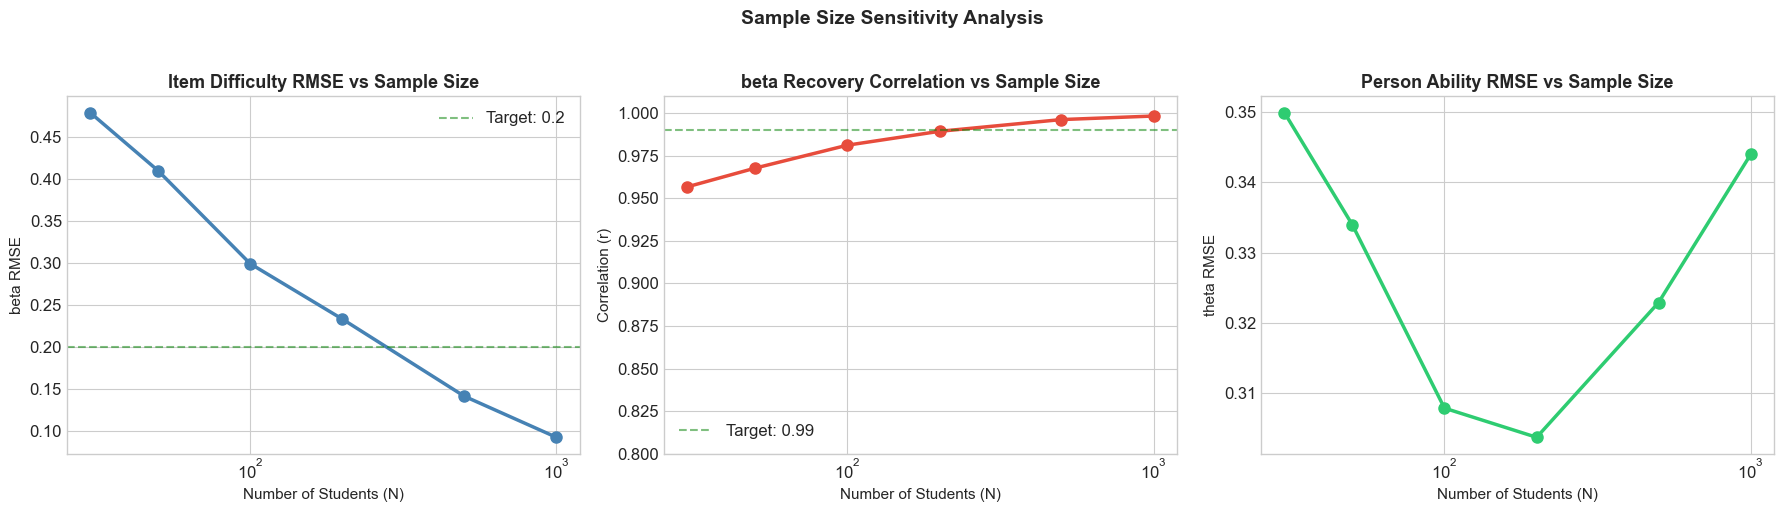


Sample size analysis complete


In [7]:
sample_sizes = [30, 50, 100, 200, 500, 1000]
J = 55  # items matching our exam

beta_rmses = []
beta_corrs = []
theta_rmses = []

for N in sample_sizes:
    print(f"Running N={N}...", end=" ")
    r = run_recovery_analysis(N, J, seed=42)
    beta_rmses.append(r['rmse'])
    beta_corrs.append(r['corr'])
    
    # Theta RMSE
    true_t = r['true_thetas'] - r['true_thetas'].mean()
    est_t = r['est_thetas'] - r['est_thetas'].mean()
    theta_rmses.append(np.sqrt(np.mean((true_t - est_t) ** 2)))
    print(f"beta RMSE={r['rmse']:.3f}, r={r['corr']:.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.plot(sample_sizes, beta_rmses, 'o-', color='steelblue', linewidth=2.5, markersize=8)
ax1.set_xlabel('Number of Students (N)', fontsize=11)
ax1.set_ylabel('beta RMSE', fontsize=11)
ax1.set_title('Item Difficulty RMSE vs Sample Size', fontsize=13, fontweight='bold')
ax1.set_xscale('log')
ax1.axhline(y=0.2, color='green', linestyle='--', alpha=0.5, label='Target: 0.2')
ax1.legend()

ax2.plot(sample_sizes, beta_corrs, 'o-', color='#e74c3c', linewidth=2.5, markersize=8)
ax2.set_xlabel('Number of Students (N)', fontsize=11)
ax2.set_ylabel('Correlation (r)', fontsize=11)
ax2.set_title('beta Recovery Correlation vs Sample Size', fontsize=13, fontweight='bold')
ax2.set_xscale('log')
ax2.set_ylim(0.8, 1.01)
ax2.axhline(y=0.99, color='green', linestyle='--', alpha=0.5, label='Target: 0.99')
ax2.legend()

ax3.plot(sample_sizes, theta_rmses, 'o-', color='#2ecc71', linewidth=2.5, markersize=8)
ax3.set_xlabel('Number of Students (N)', fontsize=11)
ax3.set_ylabel('theta RMSE', fontsize=11)
ax3.set_title('Person Ability RMSE vs Sample Size', fontsize=13, fontweight='bold')
ax3.set_xscale('log')

plt.suptitle('Sample Size Sensitivity Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_size_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSample size analysis complete")

## 7. Realistic Math Exam Simulation

Simulating a realistic 55-item math exam with:
- Items 1--35: Single answer (varied difficulty)
- Items 36--45: Paired (a+b) questions
- Student abilities: theta ~ N(0, 1) representing a typical test population
- Item difficulties: beta distributed to match a real exam curve

Total items: 55 (35 single + 20 paired parts)
Generated 500 students x 55 items response matrix
Overall correct rate: 45.7%
True theta range: [-3.24, 3.85]
True beta range: [-1.64, 2.06]

Realistic Exam Calibration Results:
  beta correlation: 0.9951
  beta RMSE: 0.1172


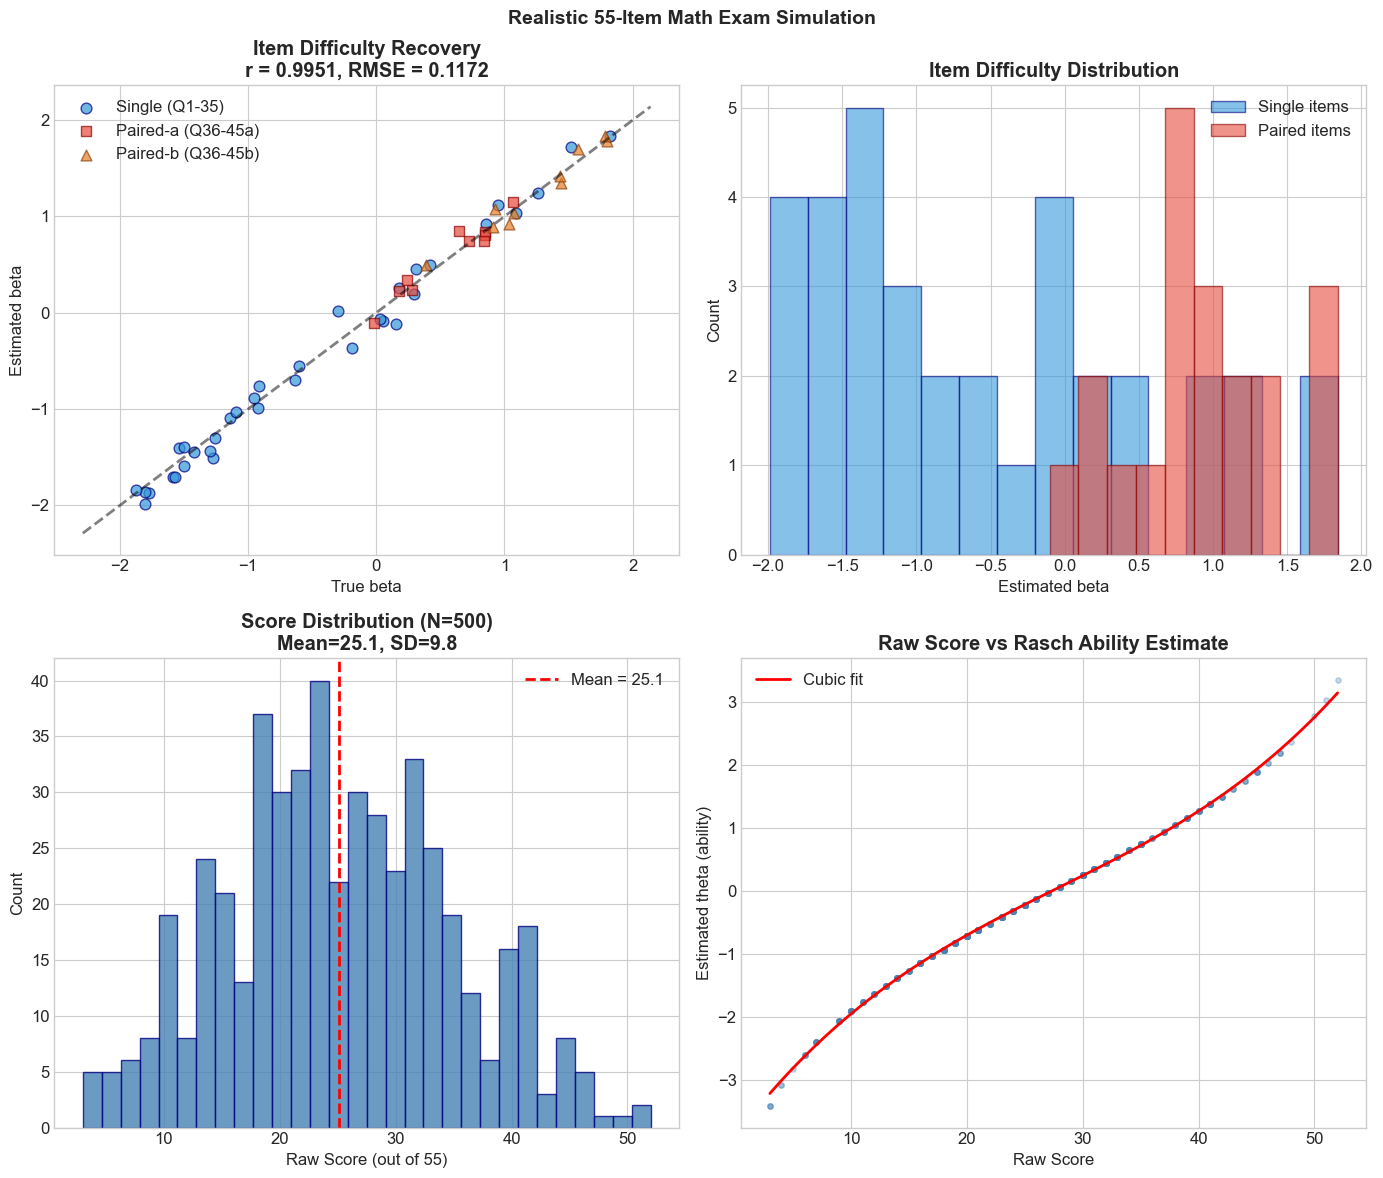

In [8]:
np.random.seed(42)

# Realistic item difficulty distribution for a math exam
# Easy questions at start, harder at end, paired questions are harder
single_betas = np.concatenate([
    np.random.normal(-1.5, 0.3, 10),   # Q1-10: Easy
    np.random.normal(-0.5, 0.4, 10),   # Q11-20: Medium-easy
    np.random.normal(0.5, 0.4, 10),    # Q21-30: Medium-hard
    np.random.normal(1.5, 0.3, 5),     # Q31-35: Hard
])

# Paired questions (a and b parts) -- generally harder
paired_betas = np.concatenate([
    np.random.normal(1.0, 0.4, 10),    # Q36-45 part a: Hard
    np.random.normal(1.5, 0.5, 10),    # Q36-45 part b: Harder
])

true_betas = np.concatenate([single_betas, paired_betas])
print(f"Total items: {len(true_betas)} (35 single + 20 paired parts)")

# 500 students with realistic ability distribution
true_thetas = np.random.normal(0.0, 1.0, 500)

# Generate responses
matrix = generate_response_matrix(true_thetas, true_betas, seed=42)

# Run calibration
est_betas, est_thetas = estimate_item_difficulties(matrix)

# Center both
true_c = true_betas - true_betas.mean()
est_c = est_betas - est_betas.mean()

corr = np.corrcoef(true_c, est_c)[0, 1]
rmse = np.sqrt(np.mean((true_c - est_c) ** 2))

print(f"\nRealistic Exam Calibration Results:")
print(f"  beta correlation: {corr:.4f}")
print(f"  beta RMSE: {rmse:.4f}")

# Detailed breakdown
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Beta recovery scatter
ax = axes[0, 0]
# Color by question type
ax.scatter(true_c[:35], est_c[:35], alpha=0.7, color='#3498db', s=60, label='Single (Q1-35)', edgecolors='navy')
ax.scatter(true_c[35:45], est_c[35:45], alpha=0.7, color='#e74c3c', s=60, label='Paired-a (Q36-45a)', edgecolors='darkred', marker='s')
ax.scatter(true_c[45:], est_c[45:], alpha=0.7, color='#e67e22', s=60, label='Paired-b (Q36-45b)', edgecolors='saddlebrown', marker='^')
lims = [min(true_c.min(), est_c.min()) - 0.3, max(true_c.max(), est_c.max()) + 0.3]
ax.plot(lims, lims, 'k--', linewidth=2, alpha=0.5)
ax.set_xlabel('True beta')
ax.set_ylabel('Estimated beta')
ax.set_title(f'Item Difficulty Recovery\nr = {corr:.4f}, RMSE = {rmse:.4f}', fontweight='bold')
ax.legend()

# 2. Difficulty distribution
ax = axes[0, 1]
ax.hist(est_c[:35], bins=15, alpha=0.6, color='#3498db', label='Single items', edgecolor='navy')
ax.hist(est_c[35:], bins=10, alpha=0.6, color='#e74c3c', label='Paired items', edgecolor='darkred')
ax.set_xlabel('Estimated beta')
ax.set_ylabel('Count')
ax.set_title('Item Difficulty Distribution', fontweight='bold')
ax.legend()

# 3. Score distribution
raw_scores = matrix.sum(axis=1)
ax = axes[1, 0]
ax.hist(raw_scores, bins=30, color='steelblue', edgecolor='navy', alpha=0.8)
ax.axvline(x=raw_scores.mean(), color='red', linewidth=2, linestyle='--', label=f'Mean = {raw_scores.mean():.1f}')
ax.set_xlabel('Raw Score (out of 55)')
ax.set_ylabel('Count')
ax.set_title(f'Score Distribution (N=500)\nMean={raw_scores.mean():.1f}, SD={raw_scores.std():.1f}', fontweight='bold')
ax.legend()

# 4. Theta vs raw score
ax = axes[1, 1]
ax.scatter(raw_scores, est_thetas, alpha=0.3, s=15, color='steelblue')
ax.set_xlabel('Raw Score')
ax.set_ylabel('Estimated theta (ability)')
ax.set_title('Raw Score vs Rasch Ability Estimate', fontweight='bold')
# Add nonlinear relationship annotation
z = np.polyfit(raw_scores, est_thetas, 3)
p = np.poly1d(z)
x_smooth = np.linspace(raw_scores.min(), raw_scores.max(), 100)
ax.plot(x_smooth, p(x_smooth), 'r-', linewidth=2, label='Cubic fit')
ax.legend()

plt.suptitle('Realistic 55-Item Math Exam Simulation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('realistic_exam_simulation.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Validation Summary

In [9]:
print("=" * 65)
print("  RASCH MODEL VALIDATION -- SUMMARY REPORT")
print("=" * 65)

print("\n  1. PARAMETER RECOVERY")
print("  " + "-" * 55)
for label, r in results.items():
    status = "PASS" if r['corr'] > 0.95 else "FAIL"
    print(f"    {label:25s}  r = {r['corr']:.4f}  RMSE = {r['rmse']:.4f}  {status}")

print(f"\n    {'Realistic Exam (500x55)':25s}  r = {corr:.4f}  RMSE = {rmse:.4f}  {'PASS' if corr > 0.95 else 'FAIL'}")

print("\n  2. FIT STATISTICS (Large Scale)")
print("  " + "-" * 55)
print(f"    Infit MNSQ:  {infits.mean():.3f} +/- {infits.std():.3f}")
print(f"    Outfit MNSQ: {outfits.mean():.3f} +/- {outfits.std():.3f}")
items_in_range = np.sum((infits >= 0.7) & (infits <= 1.3))
print(f"    Items in acceptable range: {items_in_range}/{len(infits)} ({items_in_range/len(infits)*100:.0f}%)")
fit_status = "PASS" if items_in_range / len(infits) > 0.90 else "FAIL"
print(f"    Status: {fit_status}")

print("\n  3. PERSON FIT")
print("  " + "-" * 55)
print(f"    theta correlation:  {corr_theta:.4f}")
print(f"    theta RMSE:         {rmse_theta:.4f}")
person_status = "PASS" if corr_theta > 0.90 else "FAIL"
print(f"    Status: {person_status}")

print("\n  4. SAMPLE SIZE RECOMMENDATION")
print("  " + "-" * 55)
for n, rmse_val, corr_val in zip(sample_sizes, beta_rmses, beta_corrs):
    marker = " <-- recommended minimum" if n == 200 else ""
    print(f"    N = {n:5d}:  RMSE = {rmse_val:.3f},  r = {corr_val:.4f}{marker}")

print("\n" + "=" * 65)
all_pass = (corr > 0.95) and (items_in_range / len(infits) > 0.90) and (corr_theta > 0.90)
if all_pass:
    print("  OVERALL: MODEL VALIDATED -- Ready for production with N >= 200")
else:
    print("  OVERALL: VALIDATION ISSUES FOUND -- Review above")
print("=" * 65)

  RASCH MODEL VALIDATION -- SUMMARY REPORT

  1. PARAMETER RECOVERY
  -------------------------------------------------------
    Small (20x10)              r = 0.9474  RMSE = 0.5355  FAIL
    Medium (100x55)            r = 0.9813  RMSE = 0.2991  PASS
    Large (1000x55)            r = 0.9984  RMSE = 0.0922  PASS

    Realistic Exam (500x55)    r = 0.9951  RMSE = 0.1172  PASS

  2. FIT STATISTICS (Large Scale)
  -------------------------------------------------------
    Infit MNSQ:  0.999 +/- 0.028
    Outfit MNSQ: 1.001 +/- 0.081
    Items in acceptable range: 55/55 (100%)
    Status: PASS

  3. PERSON FIT
  -------------------------------------------------------
    theta correlation:  0.9455
    theta RMSE:         0.3439
    Status: PASS

  4. SAMPLE SIZE RECOMMENDATION
  -------------------------------------------------------
    N =    30:  RMSE = 0.479,  r = 0.9568
    N =    50:  RMSE = 0.410,  r = 0.9678
    N =   100:  RMSE = 0.299,  r = 0.9813
    N =   200:  RMSE = 0.233, 